In [1]:
import skimage
from skimage.future import graph
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, segmentation
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy import spatial
from sklearn.neighbors import KDTree

import scipy
import networkx
from imageio.v2 import imread
from skimage.measure import regionprops
from tqdm import tqdm

In [2]:
file = np.load('data/cell_mask_test.npz')

In [3]:
mask = file['arr_0']

In [4]:
img = imread('data/test.png')

In [5]:
boundary_points = {}
boundary_centroids = {}
for region in regionprops(mask):
    boundary_centroids[region.label] = np.array(region.centroid).astype('int32')

In [6]:
centroids = [[x,y] for y,x in boundary_centroids.values()] +[[0,0],[0,2048],[2048,0],[2048,2048]]
centroids = np.array(centroids)

In [7]:
centroids

array([[ 558,  104],
       [ 829,  282],
       [1017,  559],
       [1795,  597],
       [1488,  440],
       [ 175,  919],
       [ 586,  679],
       [1314,  644],
       [1885, 1186],
       [ 393, 1061],
       [1387, 1026],
       [ 792, 1077],
       [ 612, 1490],
       [1434, 1757],
       [1720, 1649],
       [ 932, 1814],
       [1945, 1627],
       [ 202, 1741],
       [ 545, 1715],
       [1972, 1806],
       [   0,    0],
       [   0, 2048],
       [2048,    0],
       [2048, 2048]])

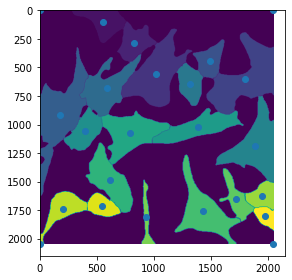

In [8]:
plt.imshow(mask)
plt.scatter(centroids[:,0], centroids[:,1])
# plt.gca().invert_yaxis()
plt.tight_layout()

In [9]:
vor = Voronoi(centroids)

<Figure size 432x288 with 0 Axes>

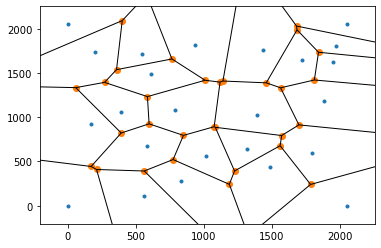

In [10]:
plt.clf()
fig = voronoi_plot_2d(vor)
# plt.imshow(mask)
plt.savefig('voronoi.png')

In [11]:
centroids_to_vertices = {}
check_valid = lambda x,y: 0<x<=2047 and 0<y<=2047
for i in range(len(vor.point_region)):
    corresponding_coord = tuple(vor.points[i].astype('int32'))
    vertices_indices = vor.regions[vor.point_region[i]]
    if not check_valid(corresponding_coord[0], corresponding_coord[1]):
        continue
    centroids_to_vertices[corresponding_coord] = set()
    for idx in vertices_indices:
        x,y = vor.vertices[idx].astype('int32')
        if not idx:
            continue
        else:
            centroids_to_vertices[corresponding_coord].add((x,y))

In [12]:
seen = set((i,i) for i in centroids_to_vertices.keys())
edges = {k:[] for k in centroids_to_vertices.keys()}
for k,v in centroids_to_vertices.items():
    for k1,v1 in centroids_to_vertices.items():
        if (k,k1) in seen or (k1, k) in seen:
            continue
        seen.add((k,k1))
        seen.add((k1,k))
        if v.intersection(v1):
            edges[k].append(k1)
            edges[k1].append(k)

In [13]:
edges

{(558, 104): [(829, 282), (586, 679)],
 (829, 282): [(558, 104), (1017, 559), (1488, 440), (586, 679)],
 (1017, 559): [(829, 282),
  (1488, 440),
  (586, 679),
  (1314, 644),
  (1387, 1026),
  (792, 1077)],
 (1795, 597): [(1488, 440), (1314, 644), (1885, 1186), (1387, 1026)],
 (1488, 440): [(829, 282), (1017, 559), (1795, 597), (1314, 644)],
 (175, 919): [(586, 679), (393, 1061), (202, 1741)],
 (586, 679): [(558, 104),
  (829, 282),
  (1017, 559),
  (175, 919),
  (393, 1061),
  (792, 1077)],
 (1314, 644): [(1017, 559), (1795, 597), (1488, 440), (1387, 1026)],
 (1885, 1186): [(1795, 597), (1387, 1026), (1720, 1649), (1945, 1627)],
 (393, 1061): [(175, 919), (586, 679), (792, 1077), (612, 1490), (202, 1741)],
 (1387, 1026): [(1017, 559),
  (1795, 597),
  (1314, 644),
  (1885, 1186),
  (792, 1077),
  (1434, 1757),
  (1720, 1649),
  (932, 1814)],
 (792, 1077): [(1017, 559),
  (586, 679),
  (393, 1061),
  (1387, 1026),
  (612, 1490),
  (932, 1814)],
 (612, 1490): [(393, 1061),
  (792, 1077)

In [14]:
graph = networkx.from_dict_of_lists(edges)

In [15]:
coloring = networkx.greedy_color(graph)

In [16]:
coloring

{(1387, 1026): 0,
 (1017, 559): 1,
 (586, 679): 0,
 (792, 1077): 2,
 (393, 1061): 1,
 (612, 1490): 0,
 (1720, 1649): 1,
 (932, 1814): 1,
 (829, 282): 2,
 (1795, 597): 1,
 (1488, 440): 0,
 (1314, 644): 2,
 (1885, 1186): 2,
 (1434, 1757): 2,
 (202, 1741): 2,
 (175, 919): 3,
 (1945, 1627): 0,
 (545, 1715): 3,
 (1972, 1806): 3,
 (558, 104): 1}

In [17]:
# assign colors to numbers
color_dict = {0:np.array((255, 0, 0)), 1:np.array((0,255,0)), 2:np.array((0,0,255)), 3:np.array((255, 255, 255))}

In [18]:
test = np.zeros((2048,2048,3)).astype('int32')
for region in regionprops(mask):
    centroid = np.array(region.centroid).astype('int32')
    color_int = coloring[(centroid[1],centroid[0])]
    color = color_dict[color_int]
    test[tuple(region.coords.T)] = color

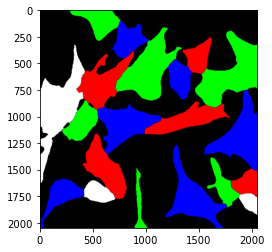

In [19]:
plt.imshow(test)